In [25]:

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
%cd /home/marcelo.silva/Projetos/BaseTrainer/seisden/notebooks

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))





/home/marcelo.silva/Projetos/BaseTrainer/seisden/notebooks


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from src.logging import PML_Logger
from src.trainer import PML_ModelTrainer
from src.templates import PML_BasicDataset


In [3]:
!ls /scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/

input_train_rsf4.npy  target_train_rsf4.npy
input_val_rsf4.npy    target_val_rsf4.npy


In [3]:
#read seismic data from a file 
train_input = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/input_train_rsf4.npy')
train_output = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/target_train_rsf4.npy')

valid_input = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/input_val_rsf4.npy')
valid_output = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/target_val_rsf4.npy')


In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim, input_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        if channels is None:
            channels = [32 * (2 ** i) for i in range(num_blocks)]
        assert len(channels) == num_blocks

        layers = []
        prev_ch = in_channels
        for ch in channels:
            layers.append(nn.Conv2d(prev_ch, ch, 3, padding=1))
            layers.append(activation())
            layers.append(nn.MaxPool2d(2))
            prev_ch = ch
        self.conv = nn.Sequential(*layers)

        # Compute flatten dim and output shape
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            enc_out = self.conv(dummy)
            self._flatten_dim = enc_out.view(1, -1).shape[1]
            self._enc_out_shape = enc_out.shape[1:]

        self.fc = nn.Linear(self._flatten_dim, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        z = self.fc(x)
        return z

    @property
    def flatten_dim(self):
        return self._flatten_dim

    @property
    def enc_out_shape(self):
        return self._enc_out_shape

class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim, enc_out_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        if channels is None:
            channels = [32 * (2 ** i) for i in range(num_blocks)]
        assert len(channels) == num_blocks

        decoder_channels = list(reversed(channels))
        prev_ch = decoder_channels[0]

        self.fc = nn.Linear(latent_dim, int(torch.prod(torch.tensor(enc_out_shape)).item()))
        layers = [nn.Unflatten(1, enc_out_shape)]
        for ch in decoder_channels[1:]:
            layers.append(nn.ConvTranspose2d(prev_ch, ch, 2, stride=2))
            layers.append(activation())
            prev_ch = ch
        layers.append(nn.ConvTranspose2d(prev_ch, out_channels, 2, stride=2))
        layers.append(nn.Sigmoid())
        self.deconv = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = self.deconv(x)
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, in_channels, latent_dim, input_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dim, input_shape, num_blocks, channels, activation)
        enc_out_shape = self.encoder.enc_out_shape
        self.decoder = Decoder(in_channels, latent_dim, enc_out_shape, num_blocks, channels, activation)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon

In [19]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.PReLU, dropout=0.1, name="conv_block"):
        super().__init__()
        self.name = name
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        #clip dropout to [0, 1] interval
        dropout = max(0, min(dropout, 1))  # Ensure dropout is in [0, 1]
        self.dropout = nn.Dropout2d(dropout)
        self.activation = activation()

    def forward(self, x):
        x = self.conv(x)
        x = self.dropout(x)
        x = self.activation(x)
        return x

    def get_name(self):
        return self.name

    def set_name(self, new_name):
        self.name = new_name

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.PReLU, dropout=0.1, name="encoder_block"):
        super().__init__()
        self.name = name
        self.conv_block_1 = ConvBlock(in_channels, out_channels, activation, dropout, name=name+"_conv_1")
        self.conv_block_2 = ConvBlock(out_channels, out_channels, activation, 2*dropout, name=name+"_conv_2")
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.pool(x)
        return x

    def get_name(self):
        return self.name

    def set_name(self, new_name):
        self.name = new_name
        self.conv_block_1.set_name(new_name+"_conv_1")
        self.conv_block_2.set_name(new_name+"_conv_2")

class EncoderFCN(nn.Module):
    def __init__(self, in_channels, channels, activation=nn.PReLU, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList()
        prev_ch = in_channels
        for idx, ch in enumerate(channels):
            block = EncoderBlock(prev_ch, ch, activation, dropout, name=f"encoder_block_{idx}")
            self.blocks.append(block)
            prev_ch = ch

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def get_block_names(self):
        return [block.get_name() for block in self.blocks]

    def set_block_name(self, idx, new_name):
        self.blocks[idx].set_name(new_name)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.PReLU, dropout=0.1, name="decoder_block"):
        super().__init__()
        self.name = name
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.up_activation = activation()
        self.conv_block = ConvBlock(out_channels, out_channels, activation, dropout, name=name+"_conv")

    def forward(self, x):
        x = self.up(x)
        x = self.up_activation(x)
        x = self.conv_block(x)
        return x

    def get_name(self):
        return self.name

    def set_name(self, new_name):
        self.name = new_name
        self.conv_block.set_name(new_name+"_conv")

class DecoderFCN(nn.Module):
    def __init__(self, out_channels, channels, activation=nn.PReLU, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList()
        decoder_channels = list(reversed(channels))
        prev_ch = decoder_channels[0]
        for idx, ch in enumerate(decoder_channels[1:]):
            block = DecoderBlock(prev_ch, ch, activation, dropout, name=f"decoder_block_{idx}")
            self.blocks.append(block)
            prev_ch = ch
        # Final upsample to output channels
        self.final_block = DecoderBlock(prev_ch, out_channels, activation, dropout, name="final_block")
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.final_block(x)
        x = self.final_activation(x)
        return x

    def get_block_names(self):
        return [block.get_name() for block in self.blocks] + [self.final_block.get_name()]

    def set_block_name(self, idx, new_name):
        if idx < len(self.blocks):
            self.blocks[idx].set_name(new_name)
        elif idx == len(self.blocks):
            self.final_block.set_name(new_name)

class FullyConvAutoencoder(nn.Module):
    def __init__(self, in_channels, out_channels, channels, activation=nn.ReLU, dropout=0.1):
        super().__init__()
        self.encoder = EncoderFCN(in_channels, channels, activation, dropout)
        self.decoder = DecoderFCN(out_channels, channels, activation, dropout)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_encoder_block_names(self):
        return self.encoder.get_block_names()

    def get_decoder_block_names(self):
        return self.decoder.get_block_names()

    def set_encoder_block_name(self, idx, new_name):
        self.encoder.set_block_name(idx, new_name)

    def set_decoder_block_name(self, idx, new_name):
        self.decoder.set_block_name(idx, new_name)


In [5]:
# ——— prepare your data ——— AUTOENCODER

def normalize_panels(x):
    # x: (N, H, W)
    x_min = x.min(axis=(1,2), keepdims=True)
    x_max = x.max(axis=(1,2), keepdims=True)
    return (x - x_min) / (x_max - x_min + 1e-10) 


train_input_norm = normalize_panels(train_input)
valid_input_norm = normalize_panels(valid_input)
print( f"train_input_norm.shape: {train_input_norm.shape} X {train_input.shape} train_input.shape")
print(f"valid_input_norm.shape: {valid_input_norm.shape} X {valid_input.shape} valid_input.shape")



train_dataset = PML_BasicDataset(train_input_norm, train_input_norm)  # both are numpy arrays
valid_dataset = PML_BasicDataset(valid_input_norm, valid_input_norm)


batch_size=64
num_workers=8
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=True)

train_input_norm.shape: (839, 1, 480, 480) X (839, 1, 480, 480) train_input.shape
valid_input_norm.shape: (361, 1, 480, 480) X (361, 1, 480, 480) valid_input.shape


In [6]:
# infer channel counts directly from your numpy arrays
in_ch  = train_input.shape[1]
out_ch = train_output.shape[1]

# Get a batch from the dataloader
x_batch, y_batch = next(iter(train_loader))
# x_batch shape: (batch_size, channels, height, width)
input_shape = tuple(x_batch.shape[1:])
print("Input shape:", input_shape)

Input shape: (1, 480, 480)


In [20]:
# ——— build model / loss / optimizer ———
# model     = SimpleCNN(in_channels=in_ch, out_channels=out_ch)
# loss_fn   = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

latent_dim=1024
num_blocks=3


       

# model     = DenoisingAutoencoder(in_channels=in_ch,
#                                  latent_dim=latent_dim,
#                                  input_shape=input_shape,
#                                  num_blocks=num_blocks,
#                                  channels=None,
#                                  activation=nn.ReLU)
# # (in_channels=in_ch, out_channels=out_ch)

# loss_fn   = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# bestweight_filename = f"best_DAE_W_l{latent_dim}_nb_{num_blocks}.pth"


channels = [32, 64, 128]
model     = FullyConvAutoencoder(in_channels=in_ch,
                                 out_channels=in_ch,
                                #  latent_dim=latent_dim,
                                #  input_shape=input_shape,
                                #  num_blocks=num_blocks,
                                 channels=channels,
                                 activation=nn.PReLU)
# (in_channels=in_ch, out_channels=out_ch)

loss_fn   = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bestweight_filename = f"best_FCN_W_l{latent_dim}_nb_{num_blocks}.pth"


In [21]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [22]:
# Calculate total parameters and estimated memory usage
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def model_size_bytes(model):
    total = 0
    for p in model.parameters():
        total += p.numel() * p.element_size()
    return total

params = count_parameters(model)
size_bytes = model_size_bytes(model)
size_mb = size_bytes / (1024 ** 2)

print(f"Total parameters: {params:,}")
print(f"Estimated size: {size_bytes:,} bytes ({size_mb:.2f} MB)")

Total parameters: 373,815
Estimated size: 1,495,260 bytes (1.43 MB)


In [23]:
# ——— plug into your trainer ———
trainer = PML_ModelTrainer(
    model        = model,
    loss_fn      = loss_fn,
    optimizer    = optimizer,
    train_loader = train_loader,
    valid_loader = valid_loader,
    seed         = 43
)

No logger provided. Using default PML_Logger.
2025-08-07 09:11:35,414 - INFO:
  [trainer.py]:146- Using 4 GPUs with DataParallel.
2025-08-07 09:11:35,416 - INFO:
  [trainer.py]:156- Model moved to cuda
2025-08-07 09:11:35,419 - INFO:
  [trainer.py]:175- Seed set to 43 (deterministic=True)
2025-08-07 09:11:35,420 - INFO:
  [trainer.py]:120- Loaders set (train + valid)
2025-08-07 09:11:35,420 - INFO:
  [trainer.py]:105- PML_ModelTrainer initialized on device: cuda


In [26]:
#load weights
state_dict = torch.load(bestweight_filename)
# If loading into a non-DataParallel model, strip 'module.' prefix
if list(state_dict.keys())[0].startswith("module."):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "", 1)] = v
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(state_dict)

In [14]:
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [24]:
# ——— run! ———
hist = trainer.fit(n_epochs=2000,
                   best_model_path=bestweight_filename,
                   n_starting_epoch=0)

[Epoch 1] Saved new best (valid_loss=3.1123e-02)
2025-08-07 09:11:46,614 - INFO:
  [trainer.py]:226- [Epoch 1/2000] train_loss=2.9038e-02, valid_loss=3.1123e-02
[Epoch 1/2000] train_loss=2.9038e-02, valid_loss=3.1123e-02
[Epoch 2] Saved new best (valid_loss=2.3569e-02)
2025-08-07 09:11:50,593 - INFO:
  [trainer.py]:226- [Epoch 2/2000] train_loss=2.9077e-02, valid_loss=2.3569e-02
[Epoch 2/2000] train_loss=2.9077e-02, valid_loss=2.3569e-02
[Epoch 3] Saved new best (valid_loss=8.8492e-03)
2025-08-07 09:11:54,836 - INFO:
  [trainer.py]:226- [Epoch 3/2000] train_loss=1.3428e-02, valid_loss=8.8492e-03
[Epoch 3/2000] train_loss=1.3428e-02, valid_loss=8.8492e-03
2025-08-07 09:11:58,657 - INFO:
  [trainer.py]:226- [Epoch 4/2000] train_loss=1.1426e-02, valid_loss=8.8817e-03
[Epoch 4/2000] train_loss=1.1426e-02, valid_loss=8.8817e-03
[Epoch 5] Saved new best (valid_loss=8.5241e-03)
2025-08-07 09:12:02,686 - INFO:
  [trainer.py]:226- [Epoch 5/2000] train_loss=1.0000e-02, valid_loss=8.5241e-03
[Epo

In [37]:
import random

# single_batch = valid_loader.__iter__().__next__()

# Get a random batch from the valid_loader
# Get a random batch from the valid_loader by iterating and breaking at a random point
num_batches = len(valid_loader)
random_batch_index = random.randint(0, num_batches - 1)
for i, (x_batch, y_batch) in enumerate(valid_loader):
    if i == random_batch_index:
        x_batch = x_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        break
# Run a single batch through the model
with torch.no_grad():
    model.eval()
    # x_batch, y_batch = single_batch
    # x_batch = x_batch.to('cuda')
    # y_batch = y_batch.to('cuda')
    
    output = model(x_batch)
    # output = output[0]  # Get the reconstruction output from the VAE
    print(f"Input shape: {x_batch.shape}, Output shape: {output.shape}, Target shape: {y_batch.shape}")


Input shape: torch.Size([64, 1, 480, 480]), Output shape: torch.Size([64, 1, 480, 480]), Target shape: torch.Size([64, 1, 480, 480])


In [11]:
import matplotlib.pyplot as plt



In [38]:
# Assuming `output`, `x_batch`, and `y_batch` are tensors from your model
# Select a random index
random_idx = torch.randint(0, x_batch.size(0), (1,)).item()

# Extract the corresponding data
x_sample = x_batch[random_idx].cpu().detach().numpy()
y_sample = y_batch[random_idx].cpu().detach().numpy()
output_sample = output[random_idx].cpu().detach().numpy()


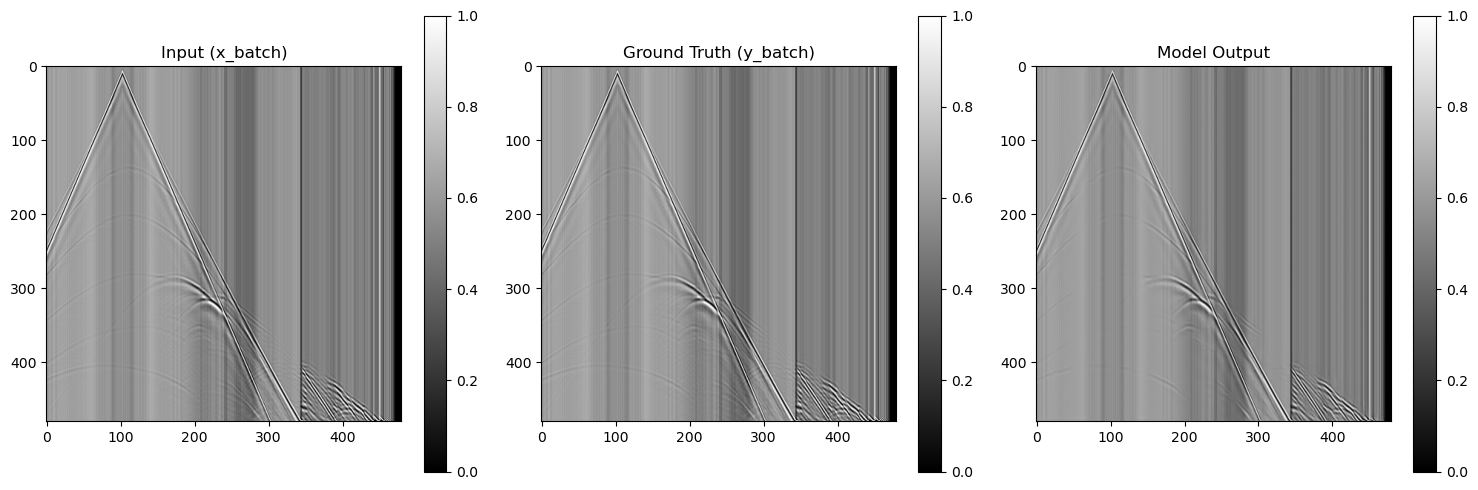

In [43]:
# Plot the data
plt.figure(figsize=(15, 5))

# Plot x_batch
plt.subplot(1, 3, 1)
plt.title("Input (x_batch)")
plt.imshow(x_sample[0], cmap='gray', vmin=0, vmax=1 )  # Assuming x_batch has a single channel
plt.colorbar()

# Plot y_batch
plt.subplot(1, 3, 2)
plt.title("Ground Truth (y_batch)")
plt.imshow(y_sample[0], cmap='gray', vmin=0, vmax=1 )  # Assuming y_batch has a single channel
plt.colorbar()

# Plot output
plt.subplot(1, 3, 3)
plt.title("Model Output")
plt.imshow(output_sample[0], cmap='gray', vmin=0, vmax=1 )  # Assuming output has a single channel
plt.colorbar()

plt.tight_layout()
plt.show()

In [31]:
def plot_seismic_data_2D_perc(data, clip_percentile=99):
    """
    Plota dados sísmicos 2D aplicando corte de percentil para eliminar outliers.
    
    Parâmetros
    ----------
    data : array_like
        Matriz 2D de amplitudes sísmicas (tempo × traços).
    clip_percentile : float, opcional
        Percentil superior para o corte. Default é 99.
        O percentil inferior será automaticamente (100 - clip_percentile).
    """
    # calcula os limites de corte
    p_low  = 100.0 - clip_percentile
    p_high = clip_percentile
    vmin = np.percentile(data, p_low)
    vmax = np.percentile(data, p_high)
    
    # aplica o corte (opcional, não altera data original)
    data_clipped = np.clip(data, vmin, vmax)
    
    # plota
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data_clipped, aspect='auto', cmap='gray',
                    vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Amplitude')
    plt.title('Seismic Data (clipped at %g%%)' % clip_percentile)
    plt.xlabel('Trace Number')
    plt.ylabel('Time Sample')
    plt.show()

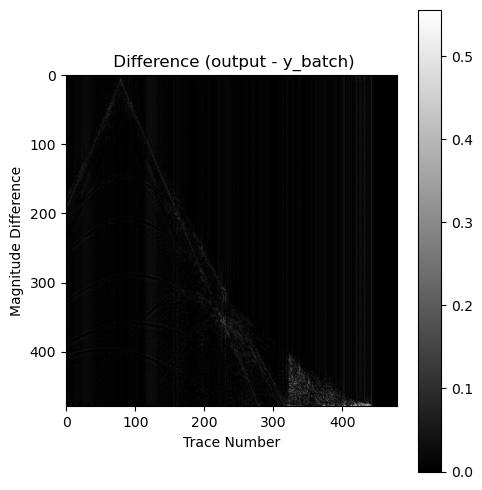

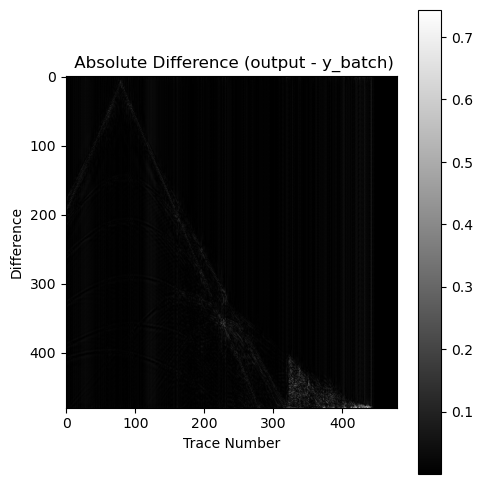

In [45]:
# plot_seismic_data_2D_perc( train_input_norm[200, 0, :, :], clip_percentile=100)
random_idx = torch.randint(0, x_batch.size(0), (1,)).item()

# Extract the corresponding data
x_sample = x_batch[random_idx].cpu().detach().numpy()
y_sample = y_batch[random_idx].cpu().detach().numpy()
output_sample = output[random_idx].cpu().detach().numpy()
# plot_seismic_data_2D_perc( np.log(np.abs(output_sample[0]- y_sample[0])+1), clip_percentile=100)

plt.figure(figsize=(5, 5))

# Plot x_batch
plt.subplot(1, 1, 1)
plt.title(" Difference (output - y_batch)")
plt.imshow( np.log(np.abs(output_sample[0]- y_sample[0])+1), cmap='gray')  # Assuming x_batch has a single channel
plt.xlabel('Trace Number')
plt.ylabel('Magnitude Difference')
plt.colorbar()
plt.tight_layout()
plt.show()



plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.title(" Absolute Difference (output - y_batch)")
plt.imshow( np.abs(output_sample[0]- y_sample[0]), cmap='gray')  # Assuming y_batch has a single channel
plt.xlabel('Trace Number')
plt.ylabel('Difference')
plt.colorbar()

plt.tight_layout()
plt.show()


# plot_seismic_data_2D_perc( output_sample[


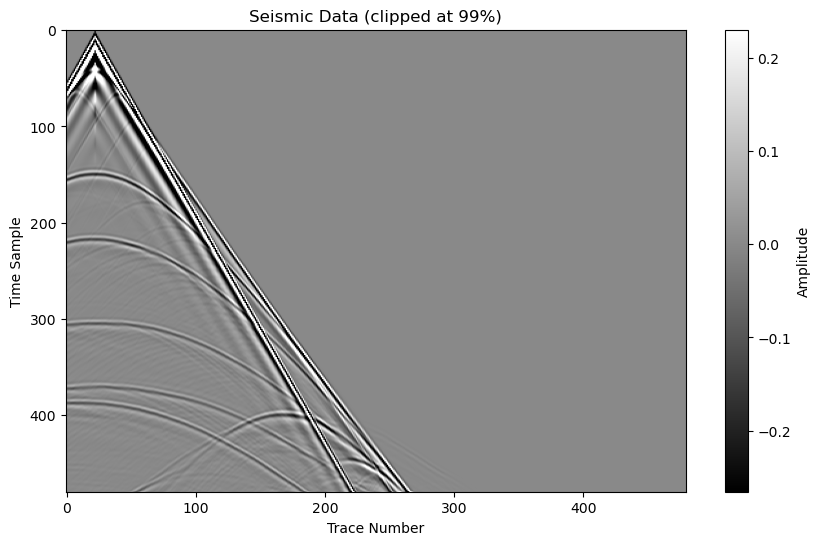

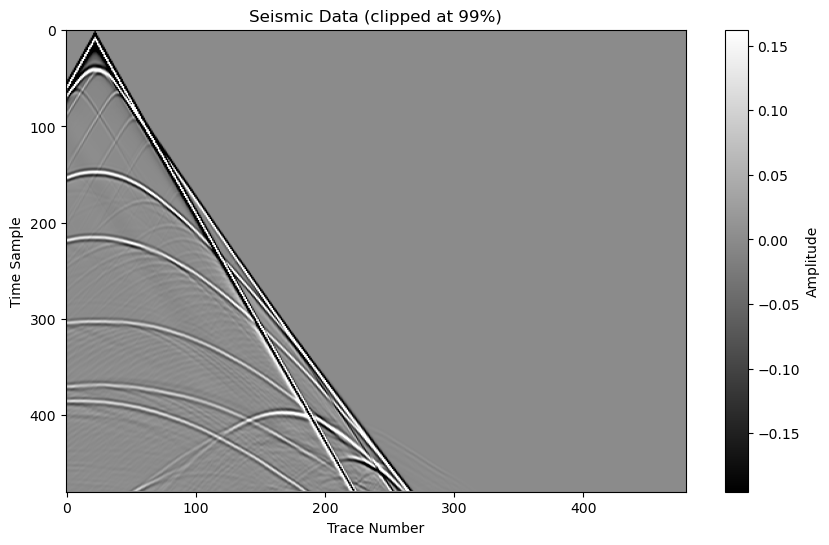

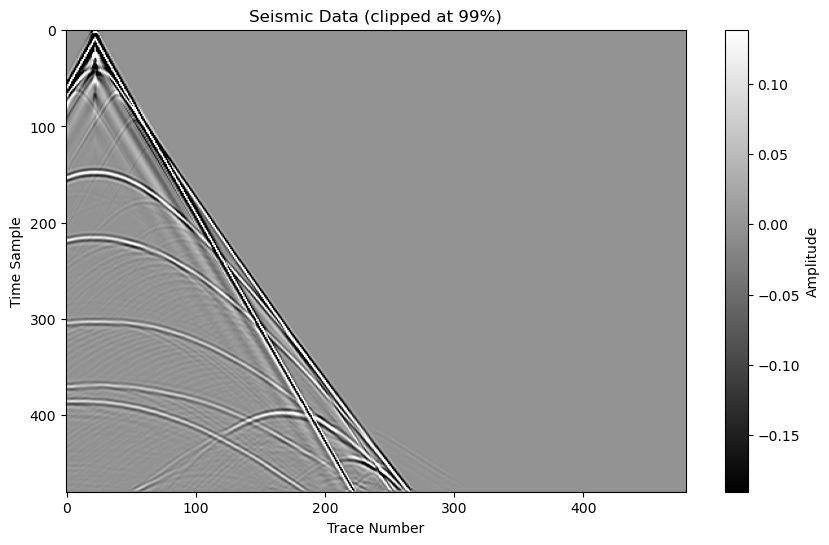

In [23]:
# Assuming `output`, `x_batch`, and `y_batch` are tensors from your model
# Select a random index
random_idx = torch.randint(0, x_batch.size(0), (1,)).item()

# Extract the corresponding data
x_sample = x_batch[random_idx].cpu().detach().numpy().squeeze()
y_sample = y_batch[random_idx].cpu().detach().numpy().squeeze()
output_sample = output[random_idx].cpu().detach().numpy().squeeze()


plot_seismic_data_2D_perc(x_sample, clip_percentile=99)
plot_seismic_data_2D_perc(y_sample, clip_percentile=99)
plot_seismic_data_2D_perc(output_sample, clip_percentile=99)